In [1]:
using NPZ
using PyPlot
using ODE
using DynamicalSystems
using LinearAlgebra
using OrdinaryDiffEq
using DifferentialEquations
using Statistics
using KrylovKit
using Arpack
using Dates

In [2]:
@inline @inbounds function loop(u, p, t)
    (a1, a2, a3, a4, k, D, beta, Lambd, lambd) = p
    A = @SMatrix[-beta/Lambd lambd D/Lambd 1/Lambd 0;
     beta/Lambd -lambd 0 0 0;
     a1 0 -a2 0 0;
     0 0 0 0 1;
     0 0 k -a4 -a3]
    (du1, du2, du3, du4, du5) = A * [u[1]; u[2]; u[3]; u[4]; u[5]] + [1/Lambd * u[1] * u[4] + D / Lambd * u[1] * u[3]; 0; 0; 0; 0]
    return SVector{5}(du1, du2, du3, du4, du5)
end

# Jacobian:
@inline @inbounds function loop_jac(u, p, t)
    (a1, a2, a3, a4, k, D, beta, Lambd, lambd) = p
    J = @SMatrix[(-beta/Lambd+1/Lambd*u[4]+D/Lambd * u[3]) lambd (D/Lambd + D/Lambd*u[1]) (1/Lambd+1/Lambd * u[1]) 0;
     beta/Lambd -lambd 0 0 0;
     a1 0 -a2 0 0;
     0 0 0 0 1;
     0 0 k -a4 -a3]
    return J
end

loop_jac (generic function with 1 method)

In [3]:
a1 = 25.04
a2 = 0.23
a3 = 2.25
a4 = 6.82
k0 = -3.7e-3
D = -2.52e-5
beta = 0.0056
Lambd = 4e-5
lambd = 0.08
p = [a1, a2, a3, a4, k0, D, beta, Lambd, lambd]

9-element Array{Float64,1}:
 25.04
  0.23
  2.25
  6.82
 -0.0037
 -2.52e-5
  0.0056
  4.0e-5
  0.08

In [4]:
start_time = Dates.now() 
# Euler integral
dt = 0.0001
t = 1000
ts = [0:dt:t;]
Nsteps = Int(1 + t / dt)
tolerance = 1e-4

#parameters
ks = [0.9:0.01:4.0;]
#ks = [2.0]
ks_len = length(ks) 
lambds_k = zeros(ks_len, 5)

#xs = zeros(Nsteps, 5)
#xs[1,:] = [0.1, 0., 0., 0., 0.]

Threads.@threads for j = 1:ks_len
    
k_k0 = ks[j]
println("j: ", j)
# lambds sampling steps
lambd_step = 10000
lambds = zeros(Int(floor(Nsteps / lambd_step)), 5)

dus_norm = zeros(Nsteps, 5)

# define initial conditions
x = zeros(5)
x[1] = 0.1
delta = I(5)

p = [a1, a2, a3, a4, k0 * k_k0, D, beta, Lambd, lambd]
    
    
# simulate the transition (100 seconds) to obtain the new IC
for i = 1: Int(100/dt)
    k1 = dt * loop(x, p, 0)
    k2 = dt * loop(x + k1 / 2, p, 0)
    k3 = dt * loop(x + k2 / 2, p, 0)
    k4 = dt * loop(x + k3, p, 0)
        
    x = (k1 + 2 * k2 + 2 * k3 + k4) / 6 + x        
end
    
# start simulation    
i = 1
while i <= Nsteps
            
    k1 = dt * loop_jac(x, p, 0) * delta
    k2 = dt * loop_jac(x, p, 0) * (delta + k1 / 2)
    k3 = dt * loop_jac(x, p, 0) * (delta + k2 / 2)
    k4 = dt * loop_jac(x, p, 0) * (delta + k3)
        
    delta = (k1 + 2 * k2 + 2 * k3 + k4) / 6 + delta
    
    #println(delta)--------------------
    du1 = delta[:,1]
    P1 = 1 / (du1' * du1) * du1 * du1'
    du2 = delta[:,2] - P1 * delta[:,2]
    P2 = 1 / (du2' * du2) * du2 * du2'
    du3 = delta[:,3] - P1 * delta[:,3] - P2 * delta[:,3]
    P3 = 1 / (du3' * du3) * du3 * du3'
    du4 = delta[:,4] - P1 * delta[:,4] - P2 * delta[:,4] - P3 * delta[:, 4]
    P4 = 1 / (du4' * du4) * du4 * du4'
    du5 = delta[:,5] - P1 * delta[:,5] - P2 * delta[:,5] - P3 * delta[:, 5] - P4 * delta[:, 5]
    
    dus_norm[i, 1] = sum(du1.^2)^0.5
    dus_norm[i, 2] = sum(du2.^2)^0.5
    dus_norm[i, 3] = sum(du3.^2)^0.5
    dus_norm[i, 4] = sum(du4.^2)^0.5
    dus_norm[i, 5] = sum(du5.^2)^0.5
    
    delta[:, 1] = du1 / dus_norm[i, 1]
    delta[:, 2] = du2 / dus_norm[i, 2]
    delta[:, 3] = du3 / dus_norm[i, 3]
    delta[:, 4] = du4 / dus_norm[i, 4]
    delta[:, 5] = du5 / dus_norm[i, 5]
    
    if i % lambd_step == 0
        lambds[Int(i / lambd_step),1] = 1/(i*dt) * sum(log.(dus_norm[1:i,1]))
        lambds[Int(i / lambd_step),2] = 1/(i*dt) * sum(log.(dus_norm[1:i,2]))
        lambds[Int(i / lambd_step),3] = 1/(i*dt) * sum(log.(dus_norm[1:i,3]))
        lambds[Int(i / lambd_step),4] = 1/(i*dt) * sum(log.(dus_norm[1:i,4]))
        lambds[Int(i / lambd_step),5] = 1/(i*dt) * sum(log.(dus_norm[1:i,5]))
#         println("j = ", j)
#         println("x = ", x)
#         println("lambds = ", lambds[Int(i / lambd_step),:])
        if (i / lambd_step > 30) && abs(sum((lambds[Int(i / lambd_step)] - lambds[Int(i / lambd_step)-1]).^2)^0.5 / sum(lambds[Int(i / lambd_step)-1].^2)^0.5) < tolerance && abs((lambds[Int(i / lambd_step), 1] - lambds[Int(i / lambd_step)-1, 1]) / lambds[Int(i / lambd_step)-1, 1]) < tolerance
            lambds_k[j, :] = lambds[Int(i / lambd_step),:]
#             println("j2 = ", j)
#             println(lambds[Int(i / lambd_step),:])
            break
        end
    end
        
    k1 = dt * loop(x, p, 0)
    k2 = dt * loop(x + k1 / 2, p, 0)
    k3 = dt * loop(x + k2 / 2, p, 0)
    k4 = dt * loop(x + k3, p, 0)
        
    x = (k1 + 2 * k2 + 2 * k3 + k4) / 6 + x
    #xs[i, :] = x
    i = i + 1
    if i == Nsteps
        lambds_k[j, :] = lambds[Int(floor(i / lambd_step)),:]
        break
    end
            
end
    
end
end_time = Dates.now()   
println(end_time - start_time)

j: 1
j: 157
j: 53
j: 261
j: 105
j: 209
j: 2
j: 54
j: 106
j: 3
j: 158
j: 210
j: 262
j: 159
j: 107
j: 4
j: 108
j: 5
j: 109
j: 55
j: 110
j: 6
j: 7
j: 160
j: 263
j: 211
j: 56
j: 111
j: 8
j: 57
j: 9
j: 112
j: 113
j: 161
j: 264
j: 212
j: 114
j: 115
j: 58
j: 10
j: 116
j: 59
j: 117
j: 162
j: 265
j: 118
j: 213
j: 11
j: 60
j: 119
j: 120
j: 163
j: 266
j: 214
j: 121
j: 12
j: 61
j: 164
j: 122
j: 267
j: 215
j: 13
j: 123
j: 62
j: 165
j: 268
j: 124
j: 216
j: 269
j: 125
j: 14
j: 166
j: 63
j: 126
j: 217
j: 127
j: 270
j: 15
j: 167
j: 64
j: 168
j: 128
j: 169
j: 218
j: 129
j: 130
j: 271
j: 272
j: 65
j: 16
j: 170
j: 17
j: 219
j: 131
j: 273
j: 274
j: 66
j: 132
j: 171
j: 18
j: 133
j: 220
j: 134
j: 135
j: 275
j: 67
j: 172
j: 19
j: 221
j: 136
j: 137
j: 276
j: 138
j: 68
j: 173
j: 139
j: 20
j: 222
j: 140
j: 174
j: 141
j: 277
j: 69
j: 70
j: 142
j: 21
j: 143
j: 175
j: 223
j: 144
j: 145
j: 146
j: 278
j: 71
j: 147
j: 22
j: 148
j: 176
j: 224
j: 149
j: 177
j: 279
j: 72
j: 150
j: 23
j: 225
j: 151
j: 152
j: 153
j: 178
j:

In [5]:
npzwrite("BWRLES001.npy", lambds_k)
npzwrite("kk0.npy", ks)

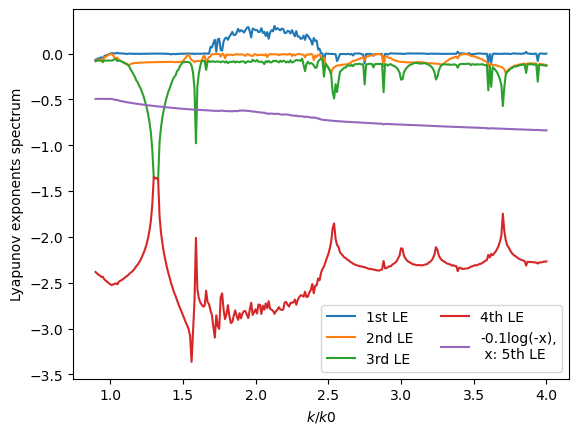

In [35]:
plot(ks, lambds_k[:,1:4])
plot(ks, -0.1*log.(-lambds_k[:, 5]))
xlabel(L"k/k0")
ylabel("Lyapunov exponents spectrum")
#PyPlot.legend(["1st LE", "2nd LE", "3rd LE", "4th LE", L"\text{sdfs}"])
PyPlot.legend(["1st LE", "2nd LE", "3rd LE", "4th LE", "-0.1log(-x),\n x: 5th LE"], loc = "lower right", ncol=2)
PyPlot.savefig("LyapunovExponentsSpectrum.png",dpi=300)